# PYBOR
PYBOR is multi-curve interest rate framework and risk engine based on multivariate optimization technique

Copyright &copy; 2017 Ondrej Martinsky, All rights reserved

[www.github.com/omartinsky/pybor](https://github.com/omartinsky/pybor)

In [2]:
%pylab
%matplotlib inline
%run jupyter_helpers
%run yc_framework
import re, random

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


### Pricing Curve Map
Generate pricing curvemap using stochastic short-rate model. This curvemap will be used only to reprice market instruments

In [3]:
def generate_pricing_curvemap():
    random.seed(0)
    pricing_curvemap = CurveMap()
    t = linspace(0, 365*80, 7)
    def createCurve(name, r0, speed, mean, sigma):
        return CurveConstructor.FromShortRateModel(name, t, r0, speed, mean, sigma, interpolation=InterpolationMode.CUBIC_LOGDF)
    def createCurveFromSpread(baseCurve, name, r0, speed, mean, sigma):
        out = createCurve(name, r0, speed, mean, sigma)
        out.add_another_curve(baseCurve)
        return out
    u3m = createCurve('USDLIBOR3M', 0.02, 0.03, 0.035, 5e-4)
    u6m = createCurveFromSpread(u3m, 'USDLIBOR6M', 0.01, 0.03, 0.011, 5e-4)
    u12m = createCurveFromSpread(u6m, 'USDLIBOR12M', 0.01, 0.03, 0.011, 5e-4)
    g3m = createCurveFromSpread(u3m, 'GBPLIBOR3M', 0.03, 0.03, 0.0, 5e-4)
    u1b = createCurve('USD-USDOIS', 0.01, 0.03, 0.011, 5e-4)
    g1b = createCurveFromSpread(u1b, 'GBP-GBPSONIA', 0.005, 0.03, 0.005, 5e-4)
    gu1b = createCurveFromSpread(u1b, 'GBP-USDOIS', 0.001, 0.03, 0.001, 5e-4)
    pricing_curvemap.add_curve(u3m)
    pricing_curvemap.add_curve(u6m)
    pricing_curvemap.add_curve(u12m)
    pricing_curvemap.add_curve(g3m)
    pricing_curvemap.add_curve(g1b)
    pricing_curvemap.add_curve(u1b)
    pricing_curvemap.add_curve(gu1b)
    return pricing_curvemap

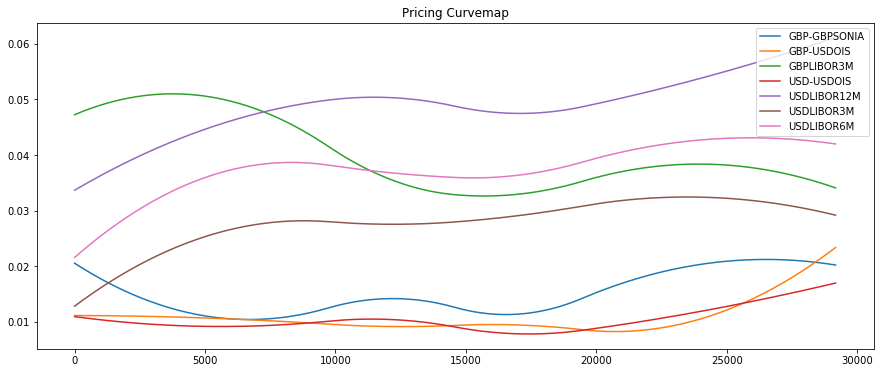

In [8]:
pricing_curvemap = generate_pricing_curvemap()
figsize(15,6)
linestyle('solid'), pricing_curvemap.plot(), title('Pricing Curvemap'), legend(), show();

### Curve Builder
Create curve builder and use previously generated pricing curvemap to reprice market instruments

In [5]:
curve_builder = CurveBuilder('engine_usd_gbp.xlsx', 0, progress_monitor=ProgressMonitor())

### Instrument Repricing
Use curve Builder to reprice instruments from previously created curve map

In [6]:
price_ladder = curve_builder.reprice(pricing_curvemap)
curve_names = curve_builder.get_curve_names()
dfs = []
for curve_name in curve_names:
    df=price_ladder.sublist(curve_name).dataframe()
    dfs.append(df)
display_dataframes(dfs)

,Price
USDLIBOR3M__Deposit__3M,1.314057
USDLIBOR3M__Future__1F_3M,98.654048
USDLIBOR3M__Future__2F_3M,98.622132
USDLIBOR3M__Future__3F_3M,98.590405
USDLIBOR3M__Future__4F_3M,98.559413
USDLIBOR3M__Future__5F_3M,98.528839
USDLIBOR3M__Future__6F_3M,98.498258
USDLIBOR3M__Future__7F_3M,98.467879
USDLIBOR3M__Future__8F_3M,98.438036
USDLIBOR3M__Future__9F_3M,98.408657


### Curve Building

In [7]:
build_output = curve_builder.build_curves(price_ladder)

Creating pillars 0 - 39 for curve USDLIBOR3M
Creating pillars 39 - 69 for curve USDLIBOR6M
Creating pillars 69 - 99 for curve USDLIBOR12M
Creating pillars 99 - 132 for curve USD-USDOIS
Creating pillars 132 - 171 for curve GBPLIBOR3M
Creating pillars 171 - 204 for curve GBP-GBPSONIA
Creating pillars 204 - 234 for curve GBP-USDOIS
.........20.........40.........60.........80.........100.........120.........140.........160.........180.........200.........220.........240.........260.........280.........300.........320.........340.........360.........380.........400.........420.........440.........460.........480.........500.........520.........540.........560.........580.........600.........620.........640.........660.........680.........700.........720.........740.........760.........780.........800.........820.........840.........860.........880.........900.........920.........940.........960.........980.........1000.........1020.........1040.........1060.........1080.........1100.......

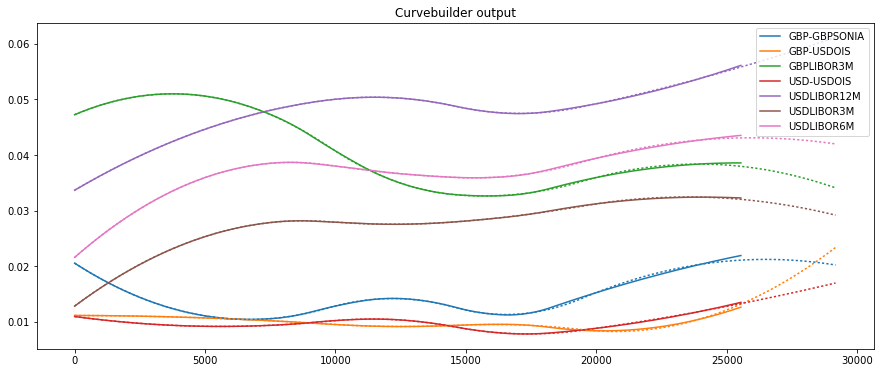

In [9]:
figsize(15,6)
title('Curvebuilder output')

linestyle('solid'), build_output.output_curvemap.plot(), legend()
linestyle('dotted'), pricing_curvemap.plot()

show();

### Instrument/Pillar Jacobian Matrix
Jacobian matrix is a by-product of a curve-build

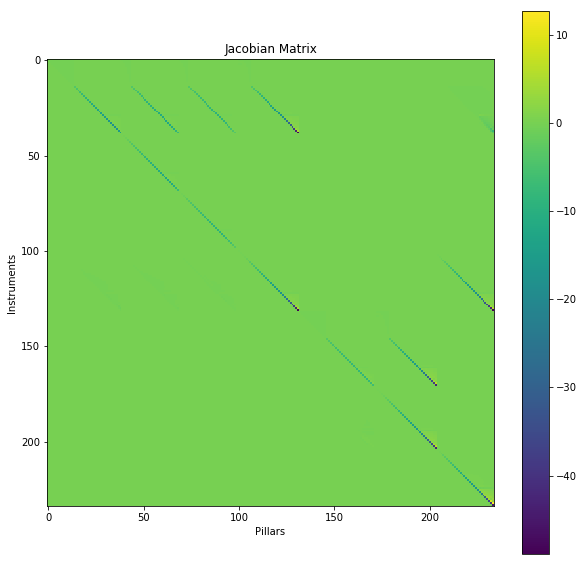

In [10]:
figsize(10,10)
title("Jacobian Matrix"), xlabel('Pillars'), ylabel('Instruments')
imshow(inv(build_output.jacobian_dIdP)), colorbar();

### Risk Calculator


In [11]:
risk_calculator = RiskCalculator(curve_builder, build_output)

### Get Bumped Curvemap

In [14]:
def visualise_bump(instrument_search_string, bumpsize):
    figsize(15,6)
    linestyle('solid')
    build_output.output_curvemap.plot(), legend()
    
    linestyle('dashed')
    instruments, bumpsize = risk_calculator.find_instruments(instrument_search_string), bumpsize  
    curvemap_bump = risk_calculator.get_bumped_curvemap(instruments, bumpsize, BumpType.JACOBIAN_REBUILD)
    curvemap_bump.plot()

    title("Effect of bumping instrument %s" % instrument_search_string), show();

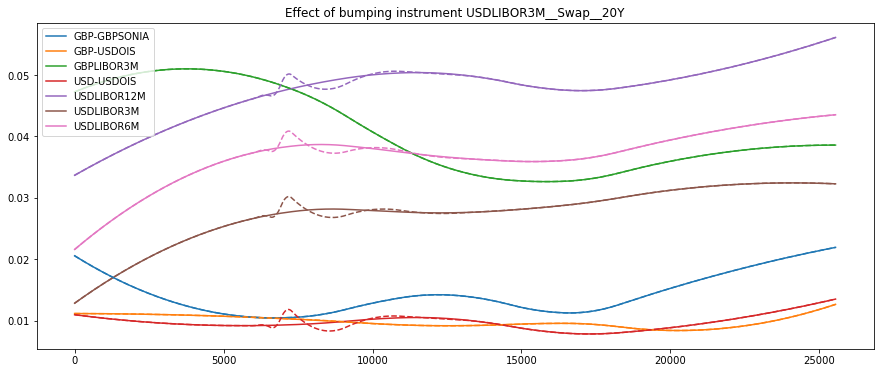

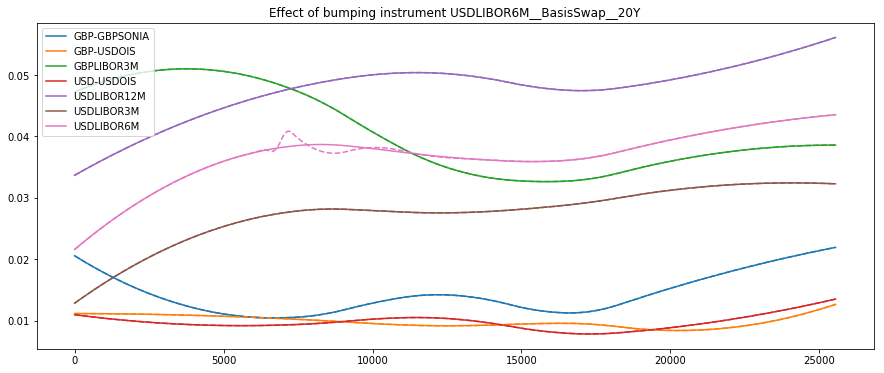

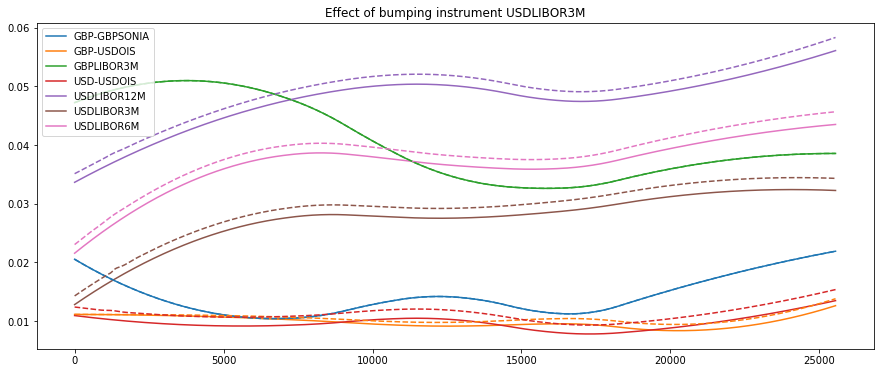

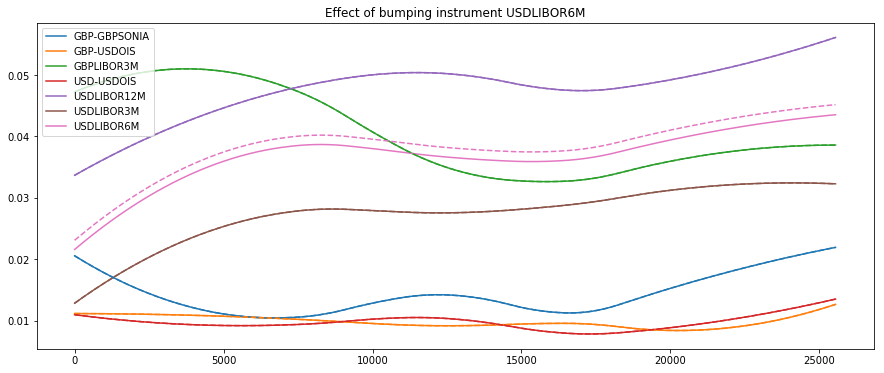

In [15]:
visualise_bump('USDLIBOR3M__Swap__20Y', 1e-4)
visualise_bump('USDLIBOR6M__BasisSwap__20Y', 1e-4)
visualise_bump('USDLIBOR3M', 15e-4)
visualise_bump('USDLIBOR6M', 15e-4)